In [367]:
"""Topic: Exploring and visualizing NFL statistics in pandas)
Web scraping data from Pro-Football-Reference for analysis
"""

from bs4 import BeautifulSoup
import requests, re
import pandas as pd
import numpy as np

from stat_functions import all_position_stats, all_rb_defense_headers
from get_df import fantasy_points, get_running_back_df, all_individual_stats

import matplotlib.pyplot as plt
%matplotlib inline

import patsy
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
df_all_running_backs_2019 = all_position_stats('2019','rushing', 37)
df_all_running_backs_2019.columns = all_rb_defense_headers('2019','rushing')
df_all_running_backs_2019.to_pickle("./pickled/df_all_running_backs_2019.pkl")

# Pickling
df_all_running_backs_2019[['Att','Yds','TD','Y/A','Y/G']] = df_all_running_backs_2019[['Att','Yds','TD','Y/A','Y/G']].apply(pd.to_numeric)
df_all_running_backs_2019 = df_all_running_backs_2019[(df_all_running_backs_2019.Pos != 'QB')]
df_all_running_backs_2019 = pd.read_pickle("./pickled/df_all_running_backs_2019.pkl")
df_all_running_backs_2019


,Link,Player,Tm,Age,Pos,G,GS,Att,Yds,TD,1D,Lng,Y/A,Y/G,Fmb
Derrick Henry,/players/H/HenrDe00.htm,Derrick Henry *,TEN,25,RB,15,15,303,1540,16,73,74,5.1,102.7,5
Ezekiel Elliott,/players/E/ElliEz00.htm,Ezekiel Elliott*,DAL,24,RB,16,16,301,1357,12,78,33,4.5,84.8,3
Nick Chubb,/players/C/ChubNi00.htm,Nick Chubb*,CLE,24,RB,16,16,298,1494,8,62,88,5.0,93.4,3
Christian McCaffrey,/players/M/McCaCh01.htm,Christian McCaffrey *+,CAR,23,RB,16,16,287,1387,15,57,84,4.8,86.7,1
Chris Carson,/players/C/CarsCh00.htm,Chris Carson,SEA,25,RB,15,15,278,1230,7,75,59,4.4,82.0,7
Joe Mixon,/players/M/MixoJo00.htm,Joe Mixon,CIN,23,RB,16,15,278,1137,5,56,41,4.1,71.1,0
Leonard Fournette,/players/F/FourLe00.htm,Leonard Fournette,JAX,24,RB,15,15,265,1152,3,55,81,4.3,76.8,1
Dalvin Cook,/players/C/CookDa01.htm,Dalvin Cook*,MIN,24,RB,14,14,250,1135,13,60,75,4.5,81.1,4
Marlon Mack,/players/M/MackMa00.htm,Marlon Mack,IND,23,RB,14,12,247,1091,8,67,63,4.4,77.9,0
Sony Michel,/players/M/MichSo00.htm,Sony Michel,NWE,24,RB,16,14,247,912,7,55,26,3.7,57.0,2


In [27]:
# all_running_backs_2019 = all_individual_stats(get_running_back_df, df_all_running_backs_2019, '2019')
# all_running_backs_2019.to_pickle("./pickled/all_running_backs_2019.pkl")

all_running_backs_2019 = pd.read_pickle("./pickled/all_running_backs_2019.pkl")
all_running_backs_2019

,index,Name,Date,Game,Team,Carries,Rush_Yards,Yards_per_Carry,Rush_TD,Receptions,Receiving_Yards,Y/R,Receiving_TD
0,0,Derrick Henry,2019-09-08,1,TEN,19.0,84.0,4.42,1.0,1.0,75.0,75.00,1.0
1,1,Derrick Henry,2019-09-15,2,TEN,15.0,82.0,5.47,1.0,2.0,12.0,6.00,0.0
2,2,Derrick Henry,2019-09-19,3,TEN,17.0,44.0,2.59,1.0,1.0,2.0,2.00,0.0
3,3,Derrick Henry,2019-09-29,4,TEN,27.0,100.0,3.70,0.0,1.0,8.0,8.00,0.0
4,4,Derrick Henry,2019-10-06,5,TEN,20.0,78.0,3.90,1.0,0.0,0.0,,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,7,Matt Breida,2019-10-31,8,SFO,15.0,78.0,5.20,0.0,2.0,14.0,7.00,0.0
514,8,Matt Breida,2019-11-11,9,SFO,10.0,18.0,1.80,0.0,2.0,7.0,3.50,0.0
515,9,Matt Breida,2019-12-08,13,SFO,6.0,54.0,9.00,0.0,1.0,4.0,4.00,0.0
516,10,Matt Breida,2019-12-15,14,SFO,4.0,11.0,2.75,0.0,2.0,6.0,3.00,0.0


In [219]:
# all_running_backs_fantasy_2019 = all_individual_stats(fantasy_points, df_all_running_backs_2019, '2019')
# all_running_backs_fantasy_2019.to_pickle("./pickled/all_running_backs_fantasy_2019.pkl")

all_running_backs_fantasy_2019 = pd.read_pickle("./pickled/all_running_backs_fantasy_2019.pkl")
all_running_backs_fantasy_2019.tail(10)

,index,Name,Fantasy_Points
508,3,Matt Breida,24.9
509,4,Matt Breida,6.3
510,5,Matt Breida,3.6
511,6,Matt Breida,5.0
512,7,Matt Breida,9.2
513,8,Matt Breida,2.5
514,9,Matt Breida,5.8
515,10,Matt Breida,-0.3
516,11,Matt Breida,NaN
517,12,Matt Breida,1.6


In [239]:
df_rushing_fantasy_2019 = all_running_backs_2019.iloc[:,1:2]

df_rushing_fantasy_2019['Fantasy_Points'] = all_running_backs_fantasy_2019.iloc[:,-1:]

df_rushing_fantasy_2019['Receptions'] = all_running_backs_2019.iloc[:, 9:10]

df_rushing_fantasy_2019['Rush_Yards'] = all_running_backs_2019.iloc[:,6:7]
df_rushing_fantasy_2019['Receiving_Yards'] = all_running_backs_2019.iloc[:,10:11]

df_rushing_fantasy_2019['Rush_TD'] = all_running_backs_2019.iloc[:,8:9]
df_rushing_fantasy_2019['Receiving_TD'] = all_running_backs_2019.iloc[:,-1:]

df_rushing_fantasy_2019 = df_rushing_fantasy_2019.dropna()

df_rushing_fantasy_points = df_rushing_fantasy_2019[['Fantasy_Points']]

df_rushing_fantasy_2019 = df_rushing_fantasy_2019.groupby('Name').expanding().mean().reset_index()

df_rushing_fantasy_2019 = df_rushing_fantasy_2019.sort_values('level_1').reset_index()

df_rushing_fantasy_2019['Fantasy_Points'] = df_rushing_fantasy_points.iloc[:,:1]

df_rushing_fantasy_2019 = df_rushing_fantasy_2019.drop(['index','level_1'],axis=1)

df_rushing_fantasy_2019 = df_rushing_fantasy_2019.dropna()

df_rushing_fantasy_2019.to_pickle("./pickled/df_rushing_fantasy_2019.pkl")

df_rushing_fantasy_2019 = pd.read_pickle("./pickled/df_rushing_fantasy_2019.pkl")

df_rushing_fantasy_2019

,Name,Fantasy_Points,Receptions,Rush_Yards,Receiving_Yards,Rush_TD,Receiving_TD
0,Derrick Henry,15.4,1.000000,84.000000,75.000000,1.000000,1.000000
1,Derrick Henry,10.6,1.500000,83.000000,43.500000,1.000000,0.500000
2,Derrick Henry,10.8,1.333333,70.000000,29.666667,1.000000,0.333333
3,Derrick Henry,13.8,1.250000,77.500000,24.250000,0.750000,0.250000
4,Derrick Henry,3.3,1.000000,77.600000,19.400000,0.800000,0.200000
...,...,...,...,...,...,...,...
507,Matt Breida,8.8,1.833333,68.500000,12.333333,0.166667,0.166667
508,Matt Breida,24.9,1.714286,63.714286,12.714286,0.142857,0.142857
509,Matt Breida,6.3,1.750000,65.500000,12.875000,0.125000,0.125000
510,Matt Breida,3.6,1.777778,60.222222,12.222222,0.111111,0.111111


In [240]:
df_rushing_fantasy_2019.corr()

,Fantasy_Points,Receptions,Rush_Yards,Receiving_Yards,Rush_TD,Receiving_TD
Fantasy_Points,1.000000,0.085807,0.168361,0.318196,0.305922,0.282557
Receptions,0.085807,1.000000,0.206968,0.477774,-0.202854,-0.137814
Rush_Yards,0.168361,0.206968,1.000000,-0.026976,-0.214586,-0.204367
Receiving_Yards,0.318196,0.477774,-0.026976,1.000000,0.686588,0.640403
Rush_TD,0.305922,-0.202854,-0.214586,0.686588,1.000000,0.911730
Receiving_TD,0.282557,-0.137814,-0.204367,0.640403,0.911730,1.000000


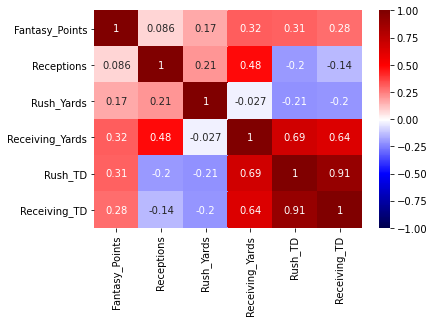

In [241]:
# example of a better corr matrix
# do this for all running backs, wide receivers, and quarterbacks
sns.heatmap(df_rushing_fantasy_2019.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

<Figure size 1440x540 with 0 Axes>

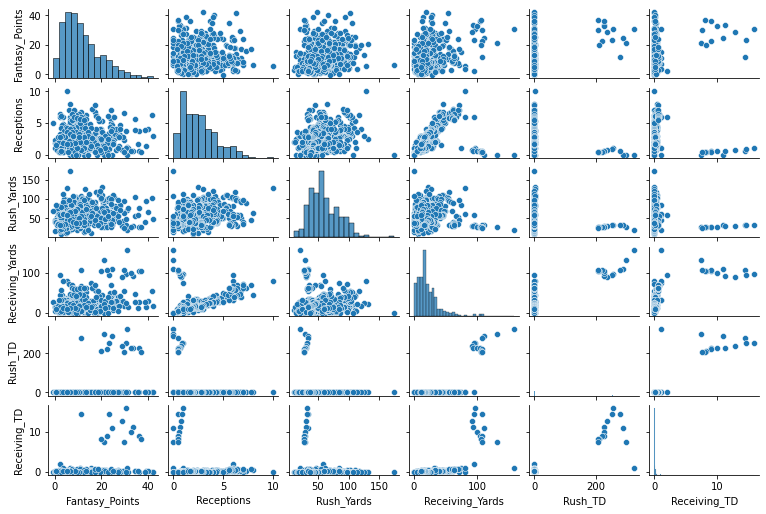

In [242]:
# do this for all running backs, wide receivers, and quarterbacks
plt.figure(figsize = [20,7.5])

sns.pairplot(df_rushing_fantasy_2019, height=1.2, aspect=1.5);

#### Cross-Validation For Model Selection

Demonstrates two typical workflows for using validation data to select models. It also demonstrates the use of some utility methods like generating **polynomial features**, converting **categorical features to "dummy variable"** binary columns, and **scaling features** when applying regularization.

**Contents Below**

> 1. Simple preprocessing and dummy variables
> 2. Basic validation method: Train/validation/test
> 3. Rigorous validation method: Cross-validation/test
> 4. Making CV less manual via scikit-learn

## 1. Preprocessing and Dummy Variables

In [259]:
pd.get_dummies(df_rushing_fantasy_2019['Name']).tail(20)

,Aaron Jones,Adrian Peterson,Alvin Kamara,Austin Ekeler,Carlos Hyde,Chris Carson,Christian McCaffrey,Dalvin Cook,David Montgomery,Derrick Henry,...,Nick Chubb,Peyton Barber,Phillip Lindsay,Raheem Mostert,Ronald Jones II,Royce Freeman,Saquon Barkley,Sony Michel,Tevin Coleman,Todd Gurley
492,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
493,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
499,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [262]:
df_rushing_fantasy_2019 = pd.get_dummies(df_rushing_fantasy_2019)
df_rushing_fantasy_2019.head(20)

,Fantasy_Points,Receptions,Rush_Yards,Receiving_Yards,Rush_TD,Receiving_TD,Name_Aaron Jones,Name_Adrian Peterson,Name_Alvin Kamara,Name_Austin Ekeler,...,Name_Nick Chubb,Name_Peyton Barber,Name_Phillip Lindsay,Name_Raheem Mostert,Name_Ronald Jones II,Name_Royce Freeman,Name_Saquon Barkley,Name_Sony Michel,Name_Tevin Coleman,Name_Todd Gurley
0,15.4,1.000000,84.000000,75.000000,1.000000,1.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10.6,1.500000,83.000000,43.500000,1.000000,0.500000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10.8,1.333333,70.000000,29.666667,1.000000,0.333333,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13.8,1.250000,77.500000,24.250000,0.750000,0.250000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.3,1.000000,77.600000,19.400000,0.800000,0.200000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,16.8,1.000000,69.333333,17.000000,0.666667,0.166667,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,6.3,1.000000,72.285714,17.142857,0.714286,0.142857,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,21.9,1.000000,72.625000,16.000000,0.625000,0.125000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,31.1,1.222222,71.555556,18.222222,0.666667,0.222222,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,27.5,1.300000,83.200000,16.700000,0.800000,0.200000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 2. Simple Validation Method: Train / Validation / Test

Break data into 3 portions: 60% for training, 20% for validation (used to select the model), 20% for final testing evaluation.

In [396]:
X, y = df_rushing_fantasy_2019.drop('Fantasy_Points',axis=1), df_rushing_fantasy_2019['Fantasy_Points']

# hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=20) #why does the random state change results??

In [397]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

Model Setup: **when using regularization, we must standardize** the data so that all features are on the same scale (we subtract the mean of each column and divide by the standard deviation, giving us features with mean 0 and std 1). Since this scaling is part of our model, we need to scale using the training set feature distributions and apply the same scaling to validation and test without refitting the scaler. 

Also, we need to get **polynomial features** for the poly model

In [398]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)
lm_las = Lasso(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [403]:
lm.fit(X_train, y_train)
# print(f'Linear Regression train R^2: {lm.score(X_train, y_train):.3f}')
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_las.fit(X_train_scaled, y_train)
# print(f'Lasso Regression train R^2: {lm_las.score(X_train, y_train):.3f}')
print(f'Lasso Regression val R^2: {lm_las.score(X_val_scaled, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
# print(f'Ridge Regression train R^2: {lm_reg.score(X_train, y_train):.3f}')
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

# lm_poly.fit(X_train_poly, y_train)
# print(f'Degree 2 polynomial regression train R^2: {lm_poly.score(X_val_poly, y_val):.3f}')
# print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.017
Lasso Regression val R^2: 0.063
Ridge Regression val R^2: 0.020


Negative R^2 equals severe overfitting! 

So having run this validation step, we see that the evidence points to Lasso regression being the best model. So our validation process lets us **select** that choice of model, and as our final step we retrain it on the entire chunk of train/val data and see how it does on test data:  

In [399]:
lm.fit(X,y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.247


## 3. Rigorous Validation Method: Cross-Validation / Test

Break data into 2 portions: 80% for a cross-validated training process, and 20% for final testing evaluation. 

Remember that the idea of CV is to make efficient use of the data available to us (using 80% instead of 60% above), while also performing multiple validation checks. For k-fold CV, we come up with k train/validation splits of the whole chunk of data, in such a way that **each observation is in the validation set exactly 1 time**. 

For simplicity we'll focus on linear regression and ridge regression (we also can feel pretty comfortable throwing out the full degree 2 polynomial regression based on the poor results above!) As we loop through our CV folds, we will train and validate both models and collect the results to compare at the end. Note that we scale the training features within the CV loop.

In [400]:
X, y = df_rushing_fantasy_2019.drop('Fantasy_Points',axis=1), df_rushing_fantasy_2019['Fantasy_Points']

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)

In [401]:
#run the CV

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_train_r2s, cv_lm_val_r2s, cv_lm_las_r2s, cv_lm_reg_r2s, rmses = [], [], [], [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)
    lm_las = Lasso(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_train_r2s.append(lm.score(X_train, y_train))
    cv_lm_val_r2s.append(lm.score(X_val, y_val))

    
    lm_rmse = mean_squared_error(y_val, lm.predict(X_val), squared=False)

    rmses.append(lm_rmse)

    # setup for ridge and lasso 
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    #lass with feature scaling 
    lm_las.fit(X_train_scaled, y_train)
    cv_lm_las_r2s.append(lm_las.score(X_val_scaled, y_val))

    #ridge with feature scaling
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_val_r2s)
print('Lasso scores: ', cv_lm_las_r2s, '\n')
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Lasso mean cv r^2: {np.mean(cv_lm_las_r2s):.3f} +- {np.std(cv_lm_las_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

print(f'Simple mean cv r^2 (TRAIN): {np.mean(cv_lm_train_r2s):.3f} +- {np.std(cv_lm_train_r2s):.3f}')
print(f'Simple mean cv r^2 (VAL): {np.mean(cv_lm_val_r2s):.3f} +- {np.std(cv_lm_val_r2s):.3f}')
print(f'Simple mean RMSE: {np.mean(rmses):.3f} +- {np.std(rmses):.3f}')

Simple regression scores:  [0.12220016723207328, 0.16456638050017813, -0.07425860247624327, -0.08081914138490554, 0.01719024839481509]
Lasso scores:  [0.1280467508034424, 0.13222589868847567, 0.08620836616568262, 0.054160564126226496, 0.06259123759139407] 

Ridge scores:  [0.12410267264781205, 0.1596424271547907, -0.06273041679691449, -0.08021433989310656, 0.020026747596118222] 

Lasso mean cv r^2: 0.093 +- 0.032
Ridge mean cv r^2: 0.032 +- 0.096
Simple mean cv r^2 (TRAIN): 0.301 +- 0.019
Simple mean cv r^2 (VAL): 0.030 +- 0.100
Simple mean RMSE: 8.017 +- 0.700


The plot thickens! Our simple validation method above pointed to simple linear regression being better than lasso and ridge, but k-fold shows the opposite. The lasso model appears to be both better on average and has less varying results.

**Since k-fold is more reliable than a single validation set, we select the lasso regression model**. This shows the dangers of relying on simple validation methods, especially when our sample sizes are small.

In [373]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_las = Lasso(alpha=1)
lm_reg = Ridge(alpha=1)

lm_las.fit(X_scaled,y)
lm_reg.fit(X_scaled,y)

print(f'Lasso Regression test R^2: {lm_.score(X_test_scaled, y_test):.3f}')
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Lasso Regression test R^2: 0.153
Ridge Regression test R^2: 0.208


In [353]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('Fantasy_Points ~ Receptions + Rush_Yards + Receiving_Yards + Rush_TD + Receiving_TD', data=df_rushing_fantasy_2019, 
return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     19.72
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           5.83e-18
Time:                        02:02:27   Log-Likelihood:                -1747.3
No. Observations:                 508   AIC:                             3507.
Df Residuals:                     502   BIC:                             3532.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.1998      1.026      5.069      0.000       3.185       7.215
Receptions          0.3291      0.409      0.804      0.422      -0.475       1.134
Rush_Yards          0.0789      0.015      5.283      0.000       0.050       0.108
Receiving_Yards     0.0289      0.044      0.652      0.514      -0.058       0.116
Rush_TD             0.0628      0.029      2.150      0.032       0.005       0.120
Receiving_TD        0.0369      0.473      0.078      0.938      -0.893       0.967
==============================================================================
Omnibus:                       80.256   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.879
Skew:                           1.026   Prob(JB):                     3.42e-27
Kurtosis:                       4.245   Cond. No.                         210.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [354]:
# Define the model
lm1 = smf.ols('Fantasy_Points ~ Receptions + Rush_Yards + Receiving_Yards + Rush_TD + Receiving_TD', data=df_rushing_fantasy_2019)

# Fit the model
fit1 = lm1.fit()

# Print summary statistics of the model's performance
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     19.72
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           5.83e-18
Time:                        02:02:27   Log-Likelihood:                -1747.3
No. Observations:                 508   AIC:                             3507.
Df Residuals:                     502   BIC:                             3532.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.1998      1.026      5.069      0.000       3.185       7.215
Receptions          0.3291      0.409      0.804      0.422      -0.475       1.134
Rush_Yards          0.0789      0.015      5.283      0.000       0.050       0.108
Receiving_Yards     0.0289      0.044      0.652      0.514      -0.058       0.116
Rush_TD             0.0628      0.029      2.150      0.032       0.005       0.120
Receiving_TD        0.0369      0.473      0.078      0.938      -0.893       0.967
==============================================================================
Omnibus:                       80.256   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.879
Skew:                           1.026   Prob(JB):                     3.42e-27
Kurtosis:                       4.245   Cond. No.                         210.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [355]:
# Define the model
lm2 = smf.ols('Fantasy_Points ~ Rush_Yards + Receiving_Yards + Rush_TD + Receiving_TD', data=df_rushing_fantasy_2019)

# Fit the model
fit2 = lm2.fit()

# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     24.51
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           1.50e-18
Time:                        02:02:27   Log-Likelihood:                -1747.6
No. Observations:                 508   AIC:                             3505.
Df Residuals:                     503   BIC:                             3526.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3700      1.003      5.352      0.000       3.399       7.341
Rush_Yards          0.0795      0.015      5.336      0.000       0.050       0.109
Receiving_Yards     0.0597      0.022      2.676      0.008       0.016       0.103
Rush_TD             0.0469      0.021      2.186      0.029       0.005       0.089
Receiving_TD        0.0951      0.468      0.203      0.839      -0.824       1.014
==============================================================================
Omnibus:                       80.891   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.777
Skew:                           1.027   Prob(JB):                     1.32e-27
Kurtosis:                       4.275   Cond. No.                         205.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [356]:
# Define the model
lm3 = smf.ols('Fantasy_Points ~ Rush_Yards + Receiving_Yards + Rush_TD', data=df_rushing_fantasy_2019)

# Fit the model
fit3 = lm3.fit()

# Print summary statistics of the model's performance
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Fantasy_Points   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     32.72
Date:                Thu, 08 Oct 2020   Prob (F-statistic):           2.44e-19
Time:                        02:02:27   Log-Likelihood:                -1747.6
No. Observations:                 508   AIC:                             3503.
Df Residuals:                     504   BIC:                             3520.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.3796      1.001      5.373      0.000       3.412       7.347
Rush_Yards          0.0795      0.015      5.338      0.000       0.050       0.109
Receiving_Yards     0.0599      0.022      2.693      0.007       0.016       0.104
Rush_TD             0.0505      0.012      4.282      0.000       0.027       0.074
==============================================================================
Omnibus:                       80.879   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.585
Skew:                           1.028   Prob(JB):                     1.46e-27
Kurtosis:                       4.268   Cond. No.                         205.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:>

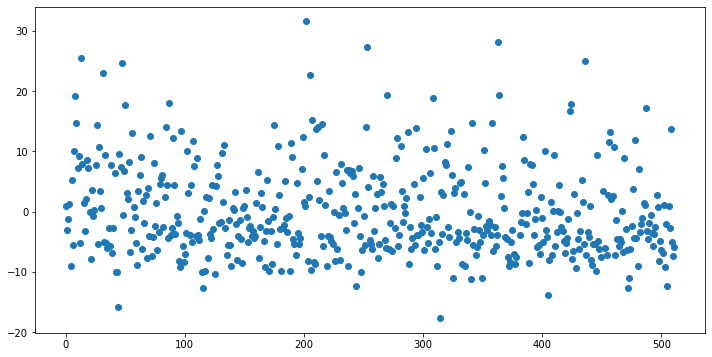

In [357]:
#Residual plot comparing actual vs. predicted values. In a good model we want our errors to be random. I'm not sure if the below looks too random. It seems to be between -5, so what does that mean? May be missing actual functional dependency underlying the data. This data may not be linear but let's keep going. 
fit1.resid.plot(style='o',figsize=(12,6))

<AxesSubplot:>

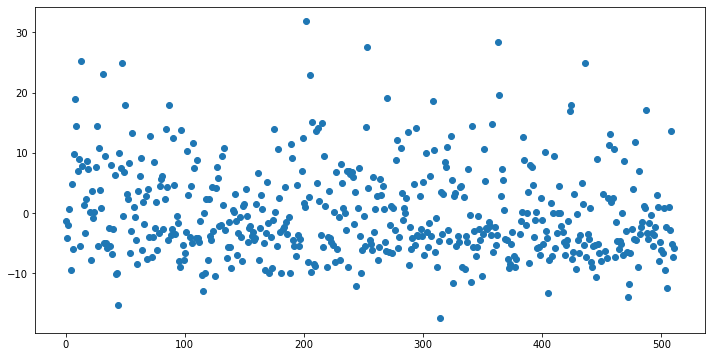

In [358]:
fit2.resid.plot(style='o',figsize=(12,6))

<AxesSubplot:>

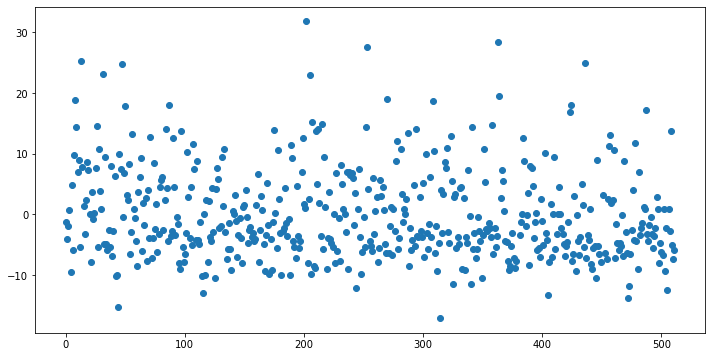

In [359]:
fit3.resid.plot(style='o',figsize=(12,6))

# Linear Regression

In [360]:
# Create an empty model
lr = LinearRegression()

# Model is analogous to 'Fantasy_Points ~ Total_Yards_Points + Total_TD_Points' model
# Predictor variables. All but the first one 
X = df_rushing_fantasy_2019.iloc[:, 2:]

# Response variables
y = df_rushing_fantasy_2019.iloc[:, 1]

# # Model fit to full dataset
lr.fit(X,y)

# # Prints R^2 for the model against the full dataset 
lr.score(X,y)

0.9329774199374676

## Linear Regression for Running Backs

In [361]:
X_train, X_test, y_train, y_test = train_test_split(df_rushing_fantasy_2019[['Receptions', 'Rush_Yards', 'Receiving_Yards', 'Rush_TD', 'Receiving_TD']], df_rushing_fantasy_2019['Fantasy_Points'], test_size=0.33, random_state=100)

lr = LinearRegression()
lr.fit(X_train,y_train)
print("Training Score: ", lr.score(X_train,y_train), "Test Score: ", lr.score(X_test,y_test))

Training Score:  0.17174792959100582 Test Score:  0.12990992558765502


In [362]:
# fig, ax = plt.subplots()

# ax.scatter(df_rushing_fantasy_2019['Rush_Yards'], df_rushing_fantasy_2019['Fantasy_Points'], alpha=0.01)

# x = np.linspace(0,1,num = 10)
# ax.scatter(x, lr.predict(x.reshape(-1,1)))

## Polynomial for Running Backs

In [363]:
p = PolynomialFeatures(degree=2)

# X_train_array = np.array(X_train.tolist()).reshape(-1,1)
# X_test_array = np.array(X_test.tolist()).reshape(-1,1)

x_train_poly = p.fit_transform(X_train)
lr.fit(x_train_poly, y_train)
print("Training Score: ", lr.score(x_train_poly, y_train), "Test Score: " , lr.score(p.transform(X_test), y_test))

Training Score:  0.23491867310579317 Test Score:  0.1686658971393109


## Lasso for Running Backs

In [364]:
L = LassoCV()
s = StandardScaler(with_mean=False)
x_train_poly_scaled = s.fit_transform(x_train_poly)
L.fit(x_train_poly_scaled, y_train)

print("Training Score: ", L.score(x_train_poly_scaled, y_train), "Test Score: " , L.score(s.transform(p.transform(X_test)),y_test))

Training Score:  0.17336239127594544 Test Score:  0.12225456056083928


In [365]:
R = RidgeCV()
R.fit(x_train_poly_scaled, y_train)

print("Training Score: ", R.score(x_train_poly_scaled, y_train), "Test Score: " , R.score(s.transform(p.transform(X_test)),y_test))

Training Score:  0.20597918074343524 Test Score:  0.1624982900280999


In [366]:
X_train, X_test, y_train, y_test = train_test_split(df_rushing_fantasy_2019[['Rush_Yards_Points']], df_rushing_fantasy_2019['Fantasy_Points'], test_size=0.33, random_state=200)

X_train = np.array(X_train.values.tolist())
X_test = np.array(X_test.values.tolist())

# Make predictions using the testing set
y_pred = m.predict(X_test)

# The coefficients
print('Coefficients: \n', m.coef_)
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
# # The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

# # Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

KeyError: "None of [Index(['Rush_Yards_Points'], dtype='object')] are in the [columns]"

In [30]:
# fig, ax = plt.subplots()

# ax.scatter = (df_rushing_fantasy_2019['Fantasy_Points'],df_rushing_fantasy_2019['Rush_Yards_Points'])

# x = np.linspace(0,1, num=10)
# ax.scatter(x, lr.predict(x.reshape(-1,1)))

In [18]:
YC_derrick_henry_rb_2019_array = np.array(derrick_henry_rb_2019_trim[['Yards_per_Carry']].values.tolist())

NameError: name 'derrick_henry_rb_2019_trim' is not defined

In [47]:
YC_derrick_henry[:-4]

array([[4.42],
       [5.47],
       [2.59],
       [3.7 ],
       [3.9 ],
       [1.87],
       [4.09],
       [4.69],
       [4.85],
       [8.17],
       [8.37]])

In [48]:
YC_derrick_henry[-4:]

array([[5.73],
       [5.72],
       [4.1 ],
       [6.59]])

Coefficients: 
 [21.07662871]
Mean squared error: 2074.19
Coefficient of determination: 0.12


[&lt;matplotlib.lines.Line2D at 0x14c1b48e0&gt;]

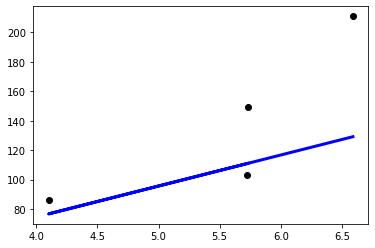

In [46]:
# Use only one feature: Carries/Game for Running Back
# X-Variable
YC_derrick_henry = YC_derrick_henry_rb_2019_array

# Split the data into training/testing sets
YC_derrick_henry_train = YC_derrick_henry[:-4]
YC_derrick_henry_test = YC_derrick_henry[-4:]

# Target Variable: Rushing Yards/Game for Running Back
# Y-Variable
yards_derrick_henry = derrick_henry_rb_2019_trim['Total_Yards']

# Split the targets into training/testing sets
yards_derrick_henry_train = yards_derrick_henry[:-4]
yards_derrick_henry_test = yards_derrick_henry[-4:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(YC_derrick_henry_train, yards_derrick_henry_train)

# Make predictions using the testing set
yards_derrick_henry_pred = regr.predict(YC_derrick_henry_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(yards_derrick_henry_test, yards_derrick_henry_pred))
# # The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(yards_derrick_henry_test, yards_derrick_henry_pred))

# # Plot outputs
plt.scatter(YC_derrick_henry_test, yards_derrick_henry_test,  color='black')
plt.plot(YC_derrick_henry_test, yards_derrick_henry_pred, color='blue', linewidth=3)

# plt.xticks(())
# plt.yticks(())

# plt.show()

# Polynomial Regression

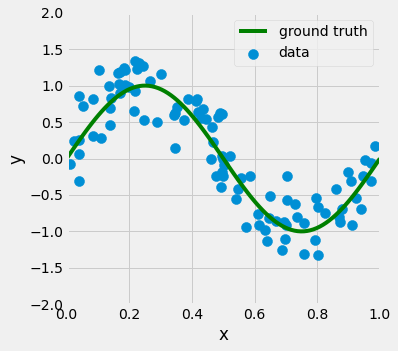

In [32]:
from IPython.core.pylabtools import figsize
figsize(5,5)
plt.style.use('fivethirtyeight')

# Seed random number generator to ensure everyone has random results
np.random.seed(9)

# Function that returns sin(2*pi*x)
def f(x):
    return np.sin(2 * np.pi * x)

# generate points used to plot
# Returns 100 evenly spaced numbers from 0 to 1
x_plot = np.linspace(0, 1, 100)

# generate points and keep a subset of them
n_samples = 100
# Generate the x values from the random uniform distribution between 0 and 1
X = np.random.uniform(0, 1, size=n_samples)[:, np.newaxis]
# Generate the y values by taking the sin and adding a random Gaussian (normal) noise term
y = f(X) + np.random.normal(scale=0.3, size=n_samples)[:, np.newaxis]

# Plot the training data against what we know to be the ground truth sin function
fig,ax = plt.subplots(1,1);
ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
ax.scatter(X, y, label='data', s=100)
ax.set_ylim((-2, 2))
ax.set_xlim((0, 1))
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.legend();

In [136]:
# import PolynomialFeatures and make_pipeline for Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Plot the results of a pipeline against ground truth and actual data
def plot_approximation(est, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
    ax.scatter(X, y, s=100)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right',frameon=True)

Generate pipeline for a 3rd degree polynomial and try plotting function. 
- Use PolynomialFeatures(3) to create a generator of 3rd degree polynomials
- Feed this generator to make_pipeline along with a LinearRegression object to tell it to string together these operations when given a new set of input predictor variables.  This results in a new model object that has the same `fit()`, `score()`, `predict()`, etc functions
- Call `fit()` on our new object to fit a 3rd degree polynomial regression
- Send the result to our plotting function to view the results

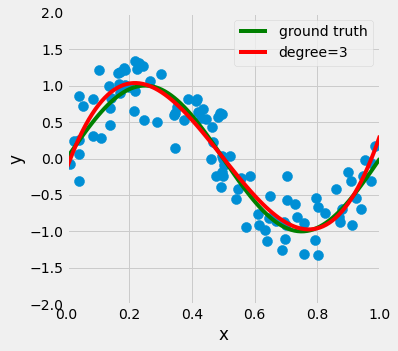

In [137]:
# Set up the plot
fig,ax = plt.subplots(1,1)
# Set the degree of our polynomial
degree = 3

# Generate the model type with make_pipeline
# This tells it the first step is to generate 3rd degree polynomial features in the input features and then run
# a linear regression on the resulting features
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit our model to the training data
est.fit(X, y)
# Plot the results
plot_approximation(est, ax, label='degree=%d' % degree)